In [1]:
import sys
sys.path.insert(0, '../../../Utilities/')
import argparse
import os
import torch
from collections import OrderedDict
import math
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
# from plotting import newfig, savefig
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torch.utils.data import TensorDataset, DataLoader
from torchvision import datasets
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch
import seaborn as sns
import pylab as py
import time
from pyDOE import lhs
import warnings
sys.path.insert(0, '../../../Scripts/')
from models_pde import Net
from pinn import *
# from ../Scripts/helper import *

warnings.filterwarnings('ignore')

np.random.seed(1234)

In [2]:
# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
device

device(type='cuda')

In [3]:
num_epochs = 30000
lambda_phy = 1

noise = 0.0

## Network Architecture
hid_dim = 128
num_layer = 4


In [4]:
# Doman bounds
lb = np.array([-1.0, 0.0])
ub = np.array([1.0, 1.0])

N0 = 100
N_b = 100
N_f = 20000
# layers = [2, 100, 100, 100, 100, 2]

data = scipy.io.loadmat('AC.mat')

t = data['tt'].flatten()[:,None] # 201
x = data['x'].flatten()[:,None]  # 512
Exact = np.real(data['uu'])

X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_star = Exact.T.flatten()[:,None]

###########################

idx_x = np.random.choice(x.shape[0], N0, replace=False)
x0 = x[idx_x,:]
u0 = Exact[idx_x,0:1]

idx_t = np.random.choice(t.shape[0], N_b, replace=False)
tb = t[idx_t,:]

X_f = lb + (ub-lb)*lhs(2, N_f)

X0 = np.concatenate((x0, 0*x0), 1) # (x0, 0)
X_lb = np.concatenate((0*tb + lb[0], tb), 1) # (lb[0], tb)
X_ub = np.concatenate((0*tb + ub[0], tb), 1) # (ub[0], tb)

In [5]:
net = Net(in_dim = 2, out_dim = 1, hid_dim = hid_dim, num_layers = num_layer).to(device)

ACs = AC_PINN(X0, u0, X_f, X_lb, X_ub, net, device, num_epochs, lambda_phy, noise)
 
ACs.train()

[Epoch 0/30000] [MSE loss: 0.136716] [Phy loss: 0.004277] [Total loss: 0.141609]
[Epoch 100/30000] [MSE loss: 0.139773] [Phy loss: 0.003462] [Total loss: 0.144373]
[Epoch 200/30000] [MSE loss: 0.133183] [Phy loss: 0.003354] [Total loss: 0.137752]
[Epoch 300/30000] [MSE loss: 0.131348] [Phy loss: 0.005974] [Total loss: 0.138151]
[Epoch 400/30000] [MSE loss: 0.122655] [Phy loss: 0.007486] [Total loss: 0.130784]
[Epoch 500/30000] [MSE loss: 0.125693] [Phy loss: 0.006913] [Total loss: 0.133086]
[Epoch 600/30000] [MSE loss: 0.121174] [Phy loss: 0.007412] [Total loss: 0.129026]
[Epoch 700/30000] [MSE loss: 0.123736] [Phy loss: 0.007394] [Total loss: 0.131495]
[Epoch 800/30000] [MSE loss: 0.131050] [Phy loss: 0.007662] [Total loss: 0.138934]
[Epoch 900/30000] [MSE loss: 0.121329] [Phy loss: 0.010021] [Total loss: 0.131557]
[Epoch 1000/30000] [MSE loss: 0.119388] [Phy loss: 0.009522] [Total loss: 0.129083]
[Epoch 1100/30000] [MSE loss: 0.131741] [Phy loss: 0.009306] [Total loss: 0.141369]
[Epo

In [6]:
u_pred_list = []
f_pred_list = []

for run in range(1):
    u_pred, f_pred = ACs.get_residual(X_star)
    u_pred_list.append(u_pred.detach().cpu().numpy())
    f_pred_list.append(f_pred.detach().cpu().numpy())

u_pred_arr = np.array(u_pred_list)
f_pred_arr = np.array(f_pred_list)
u_pred = u_pred_arr.mean(axis=0)
f_pred = f_pred_arr.mean(axis=0)
u_dev = u_pred_arr.var(axis=0)
f_dev = f_pred_arr.var(axis=0)

error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
print('Error u: %e' % (error_u))                     
print('Residual: %e' % (f_pred**2).mean())
U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')
U_dev = griddata(X_star, u_dev.flatten(), (X, T), method='cubic')
Error = np.abs(Exact - U_pred.T)

Error u: 5.320881e-01
Residual: 7.066075e-05


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, 'Prediction $u(x,t)$')

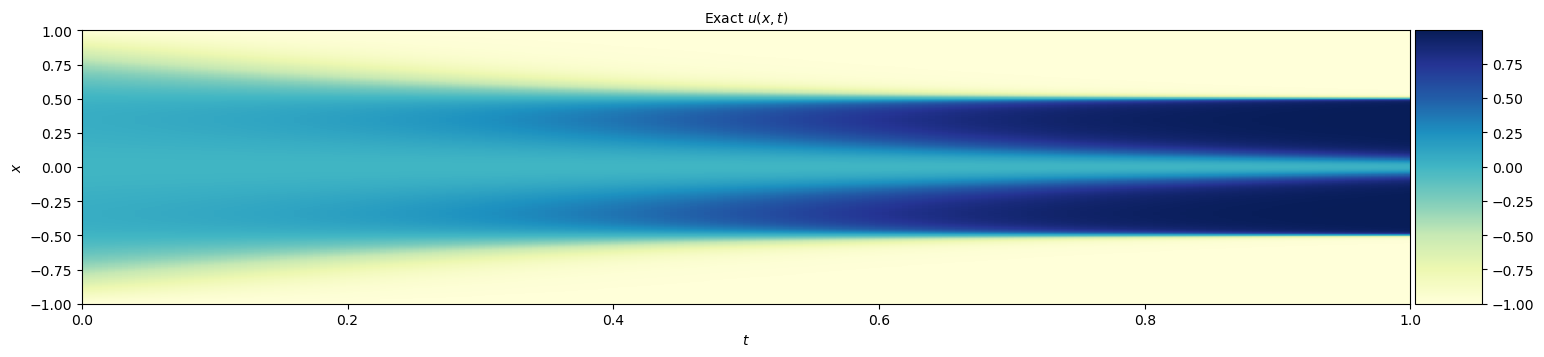

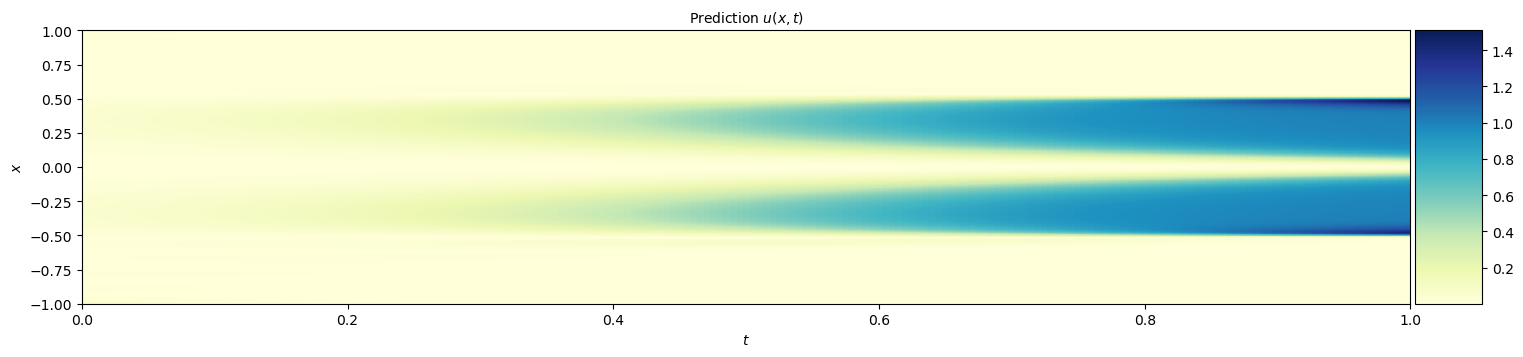

In [18]:
######################################################################
############################# Plotting ###############################
######################################################################    
# t = data['tt'].flatten()[:,None]
# x = data['x'].flatten()[:,None]

# X0 = np.concatenate((x0, 0*x0), 1) # (x0, 0)
# X_lb = np.concatenate((0*tb + lb[0], tb), 1) # (lb[0], tb)
# X_ub = np.concatenate((0*tb + ub[0], tb), 1) # (ub[0], tb)
# X_u_train = np.vstack([X0, X_lb, X_ub])

# fig, ax = newfig(1.0, 0.9)
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
ax.axis('off')

####### Row 0: h(t,x) ##################    
gs0 = gridspec.GridSpec(1, 2)
gs0.update(top=1-0.06, bottom=1-1/3, left=0.15, right=0.85, wspace=0)
ax = plt.subplot(gs0[:, :])

h = ax.imshow(Exact, interpolation='nearest', cmap='YlGnBu', 
              extent=[lb[1], ub[1], lb[0], ub[0]], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)

ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
leg = ax.legend(frameon=False, loc = 'best')
#    plt.setp(leg.get_texts(), color='w')
ax.set_title('Exact $u(x,t)$', fontsize = 10)

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
ax.axis('off')

####### Row 0: h(t,x) ##################    
gs0 = gridspec.GridSpec(1, 2)
gs0.update(top=1-0.06, bottom=1-1/3, left=0.15, right=0.85, wspace=0)
ax = plt.subplot(gs0[:, :])

# error  = griddata(X_star, np.abs(u_star-U_pred).flatten(), (X, T), method='cubic')


h = ax.imshow(np.abs(Exact - U_pred.T), interpolation='nearest', cmap='YlGnBu', 
              extent=[lb[1], ub[1], lb[0], ub[0]], 
              origin='lower', aspect='auto')



# h = ax.imshow(U_pred.T, interpolation='nearest', cmap='YlGnBu', 
#               extent=[lb[1], ub[1], lb[0], ub[0]], 
#               origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)

  

ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
leg = ax.legend(frameon=False, loc = 'best')
#    plt.setp(leg.get_texts(), color='w')
ax.set_title('Prediction $u(x,t)$', fontsize = 10)


